In [1]:
import pandas as pd
import numpy as np
from time import time
import os
import random
import xlrd
import xlwt
import pywt
from scipy import optimize
import scipy
from sklearn import preprocessing
from tqdm import tqdm_notebook
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import manifold
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# 背景扣除

def simulate_background(x):
    x = x.tolist()
    peak_list = find_peak(x)
    peak_position_list = [i for i, x in enumerate(x) if x in peak_list]
    min_list = [min(x[peak_position_list[i]:peak_position_list[i+1]]) for i in range(len(peak_position_list)-1)]
    min_new_list = min_list
    for index in range(1, len(min_list)-1, 1):
        if min_list[index] != 0:
            if min_list[index-1] != 0 and min_list[index+1] != 0:
                if min_list[index] > 1.2*min_list[index-1] and min_list[index] > 1.2*min_list[index+1]:
                    min_new_list[index] = 0.5*(min_list[index-1] + min_list[index+1])
    for index in range(len(peak_position_list)-1):
        x_change = x[peak_position_list[index]:peak_position_list[index+1]]
        x_change = [min_new_list[index] for i in range(len(x_change))]
        x[peak_position_list[index]:peak_position_list[index + 1]] = x_change
    x = np.array(x)
    return x

def find_peak(x):
    peak = []
    for index in range(1, len(x)-1, 1):
        if x[index-1] < x[index] and x[index] > x[index+1]:
            peak.append(x[index])
    return peak

def correct_background(x):
    x = np.maximum(x, 0)
    x = x-simulate_background(x)
    return x

def wavelet_de_noising(x, threshold=None):
    # Create wavelet object and define parameters
    w = pywt.Wavelet('haar')
    maxlev = pywt.dwt_max_level(len(x), w.dec_len)
    #print("maximum level is " + str(maxlev))
    threshold = threshold  # Threshold for filtering
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(x, 'haar', level=maxlev)  # 将信号进行小波分解
    #print(coeffs)
    for i in range(1, len(coeffs)):
        std_cache = np.std(coeffs[i], ddof=1)
        #print(std_cache)
        threshold_def = 3 * std_cache
        if threshold is None:
            coeffs[i] = pywt.threshold(coeffs[i], threshold_def)  # 将噪声滤波
        else:
            coeffs[i] = pywt.threshold(coeffs[i], threshold)  # 将噪声滤波
        #coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))  # 将噪声滤波
    #print(coeffs)
    datarec = pywt.waverec(coeffs, 'haar')  # 将信号进行小波重构
    return datarec

def remove_invalid_matrix(x, pixel, threshold=1000):
    x_column = x[:, pixel].tolist()
    valid_row_order = [i for i, x in enumerate(x_column) if x >= threshold]
    x = x[valid_row_order, :]
    return x

def mean_spectra_new(x, n, s):
    r_in, c_in = x.shape
    r_out = int((r_in+1-n)/s)
    x_out = np.zeros([r_out, c_in])
    for indexi in range(r_out):
        x_out[indexi, :] = np.mean(x[indexi*s:indexi*s+n, :], axis=0)
    return x_out

def plot_embedding(x, fig_name, path, color, text, title=None):  # text should be in str type; color in vale type
    x_min, x_max = np.min(x, 0), np.max(x, 0)
    x = (x - x_min) / (x_max - x_min)
    plt.ion()
    for index in range(x.shape[0]):
        plt.text(x[index, 0], x[index, 1],
                 text[index, 0],
                 color=plt.cm.tab20(color[index, 0]/(np.max(color)+1)),
                 fontdict={'weight': 'bold', 'size': 8})
    if title is not None:
        plt.title(title, fontsize=10)
    plt.savefig(path + '\\' + fig_name + '.png', dpi=1000, bbox_inches='tight')
    plt.pause(10)
    plt.close()
    
def find_highest_peak_position_2D(x):
    highest_peak = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] > highest_peak:
                highest_peak = x[i, j]
                highest_peak_position = [i, j]
    return highest_peak, highest_peak_position

def select_channels(x, select_horizon=20):
    highest_peak, highest_peak_position = find_highest_peak_position_2D(x)
    threshold = highest_peak / 2
    for i in range(1, select_horizon):
        if highest_peak_position[1] - i >= 0 and x[highest_peak_position[0], highest_peak_position[1] - i] < threshold:
            select_channel_bot = highest_peak_position[1] - i + 1
        elif highest_peak_position[1] - i < 0:
            select_channel_bot = 0
        if highest_peak_position[1] + i < x.shape[1] and x[highest_peak_position[0], highest_peak_position[1] + i] < threshold:
            select_channel_top = highest_peak_position[1] + i - 1
        elif highest_peak_position[1] + i == x.shape[1]:
            select_channel_top = x.shape[1] - 1
    return x[:, select_channel_bot:select_channel_top]
         
def cut_2D(x, cut_num, remove_duplicate=False):
    x_shape = np.array(x.shape)
    num = x.shape[0] * x.shape[1]
    x_cache = x.reshape(num)
    seq_num = np.zeros((cut_num, 1))
    x_sort = np.argsort(x_cache)
    print('x_sort.shape = ' + str(x_sort.shape))
    if remove_duplicate:
        if_cache = []
        removed_cache = []
        for i in tqdm_notebook(range(len(x_sort))):
            j = len(x_sort) - i - 1
            if x_cache[x_sort[j]] not in if_cache:
                if_cache.append(x_cache[x_sort[j]])
                print('x_cache[x_sort[j]] = '+str(x_cache[x_sort[j]]))
                removed_cache.append(x_sort[j])
        removed_cache = np.array(removed_cache).flatten()
        print('removed_cache.shape = ' + str(removed_cache.shape))
        #print('removed_cache = ' + str(removed_cache))
        x_sort = np.flip(removed_cache, 0)
        num2 = x_sort.shape[0]
        x_cache2 = np.zeros((num))
        for i in range(num2 - cut_num, num2):
            x_cache2[x_sort[i]] = x_cache[x_sort[i]]
        seq_num = x_sort[-cut_num:]
        print('seq_num = '+str(seq_num))
        return seq_num, x_cache2.reshape(x_shape)
    else:
        for i in range(num - cut_num):
            x_cache[x_sort[i]] = 0
        seq_num = x_sort[-cut_num:]
        return seq_num, x_cache.reshape(x_shape)         

def cut_1D(x, cut_num):
    x = x.flatten()
    num = len(x)
    seq_num = np.zeros((cut_num, 1))
    x_sort = np.argsort(x)
    seq_num = x_sort[-cut_num:]
    return seq_num

def find_sequence(seq_num, shape=[4559, 127]):
    seq_cord = np.zeros((len(seq_num), 2))
    for j in range(len(seq_num)):
        for i in range(shape[0]):
            if seq_num[j] >= i*127 and seq_num[j] < (i+1)*shape[1]:
                seq_cord[j, :] = [i, seq_num[j]-i*shape[1]]
    return seq_cord

def find_peak_positions_2D(x):
    flag = True
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if i == 0:
                left = 0
                right = x[i + 1, j]
            elif i == x.shape[0] - 1:
                left = x[i - 1, j]
                right = 0
            else:
                left = x[i - 1, j]
                right = x[i + 1, j]
            if j == 0:
                up = 0
                down = x[i, j + 1]
            elif j == x.shape[1] - 1:
                up = x[i, j - 1]
                down = 0
            else:
                up = x[i, j - 1]
                down = x[i, j + 1]
            if x[i, j] >= np.max([left, right, up, down]):
                if flag:
                    peak_pos = 127 * i + j
                    flag = False
                else:
                    peak_pos = np.row_stack((peak_pos, 127 * i + j))
    return peak_pos
            
def select_peaks(x, peak_pos, num):
    x_flat = x.reshape(-1, 1)
    x_cache = x_flat[peak_pos]
    print(x_cache.shape)
    x_sort = np.argsort(x_cache.flatten())
    print(x_sort)
    return peak_pos[x_sort[-num:]]


In [3]:
#preprocess
def preprocess_2020(x, if_correct_background=False, if_wavelet_de_noising=False, if_remove_invalid=False, 
                    if_mean=True, mean_num=[10, 5]):
    '''
    preprocess
    input: n*m array, meaning m spectra with n pixels
    attributes:
        mean_num: mean over mean_num[0] spectra, with interval of mean_num[1]
        if_header: if input data has pixels as headers
    output: array after preprocessing, transposition of input
    '''
    n = x.shape[0]
    m = x.shape[1]
    data = None
    for i in range(m):
        data_cache = x[:, i]
        if if_correct_background:
            data_cache = correct_background(data_cache)
        if if_wavelet_de_noising:
            data_cache = wavelet_de_noising(data_cache)
        if data is None:
            data = data_cache.T
        else:
            data = np.row_stack((data, data_cache.T))
    if if_remove_invalid:
        data = remove_invalid_matrix(data)
    if if_mean:
        data = mean_spectra_new(data, mean_num[0], mean_num[1])
    return data

def wavelet_transform_2020(x, t=None, totalscal=128, freq_output=False, method='cwt', level_max=None):
    '''
    wavelet_transform
    input: 1*n array, meaning 1 spectra with n pixels
    attribute:
        t: n*1, meaning n wavelengths with respect to n pixels
        totalscal: total number of scales
    output: coefficient matrix (and frequencies if freq_output)
    '''
    if method is 'cwt':
        if t is None:
            print('no freq input')
        sampling_space = (np.max(t) - np.min(t)) / len(t)
        wavename = 'cgau8'
        fc = pywt.central_frequency(wavename)
        cparam = 2 * fc * totalscal
        scales = cparam / np.arange(totalscal, 1, -1)
        [cwtmatr, frequencies] = pywt.cwt(x, scales, wavename, sampling_space)
        if freq_output:
            return abs(cwtmatr), frequencies
        else:
            return abs(cwtmatr)
    elif method is 'dwt':
        length = np.max(x.shape)
        wavename = 'db1'
        w = pywt.Wavelet(wavename)
        level_num = pywt.dwt_max_level(data_len=np.max(x.shape), filter_len=w.dec_len)
        if level_max is not None:
            if level_num > level_max:
                level_num = level_max
        coeffs = pywt.wavedec(x.flatten(), wavename, level=level_num)
        coeffs = np.array(coeffs)
        final_coeffs = np.zeros((level_num + 1, length))
        for i in range(coeffs.shape[0]):
            coeffs_len = np.max(coeffs[i].shape)
            rem = length % coeffs_len # number of coeffs that need to be duplicated by (rep_num + 1)
            rep_num = length // coeffs_len # the other part of coeffs need to be duplicated by rep_num
            if rem != 0:
                cache = []
                for j in range(rem):
                    for k in range(rep_num + 1):
                        cache.append(coeffs[i][j])
                for j in range(rem, coeffs_len):
                    for k in range(rep_num):
                        cache.append(coeffs[i][j])
                final_coeffs[i] = cache
            else:
                cache = []
                for j in range(coeffs_len):
                    for k in range(rep_num):
                        cache.append(coeffs[i][j])
                final_coeffs[i] = cache
        return final_coeffs, coeffs

In [ ]:
x = np.random.rand(23826, 1)
length = np.max(x.shape)
wavename = 'db1'
w = pywt.Wavelet(wavename)
level_num = pywt.dwt_max_level(data_len=length, filter_len=w.dec_len)
level_num = 8
coeffs = pywt.wavedec(x.flatten(), wavename, level=level_num)
coeffs = np.array(coeffs)
final_coeffs = np.zeros((level_num + 1, length))
for i in range(coeffs.shape[0]):
    coeffs_len = np.max(coeffs[i].shape)
    rem = length % coeffs_len # number of coeffs that need to be duplicated by (rep_num + 1)
    rep_num = length // coeffs_len # the other part of coeffs need to be duplicated by rep_num
    if rem != 0:
        '''vector1 = np.zeros((rem, (rep_num + 1)))
        vector1[0, :rep_num + 1] = np.ones((1, rep_num + 1))
        rep_mat1 = vector1
        for j in range(rem - 1):
            vector1 = np.roll(vector1, shift=1, axis=0)
            rep_mat1 = np.column_stack((rep_mat1, vector1))
        coeffs1 = coeffs[i][:rem].reshape(1, rem)
        final_coeffs[i, :rem * (rep_num + 1)] = coeffs1.dot(rep_mat1)
        vector2 = np.zeros((coeffs_len - rem, rep_num))
        vector2[0, :rep_num] = np.ones((1, rep_num))
        rep_mat2 = vector2
        for j in range(coeffs_len - rem - 1):
            vector2 = np.roll(vector2, shift=1, axis=0)
            rep_mat2 = np.column_stack((rep_mat2, vector2))
        coeffs2 = coeffs[i][rem:].reshape(1, coeffs_len - rem)
        final_coeffs[i, rem * (rep_num + 1):] = coeffs2.dot(rep_mat2)'''
        
        cache = []
        for j in range(rem):
            for k in range(rep_num + 1):
                cache.append(coeffs[i][j])
        for j in range(rem, coeffs_len):
            for k in range(rep_num):
                cache.append(coeffs[i][j])
        final_coeffs[i] = cache
    else:
        '''vector = np.zeros((coeffs_len, rep_num))
        vector[0, :rep_num] = np.ones((1, rep_num))
        rep_mat = vector
        for j in range(coeffs_len - 1):
            vector = np.roll(vector, shift=1, axis=0)
            rep_mat = np.column_stack((rep_mat, vector))
        coeffs0 = coeffs[i].reshape(1, coeffs_len)
        final_coeffs[i] = coeffs0.dot(rep_mat)'''
        
        cache = []
        for j in range(coeffs_len):
            for k in range(rep_num):
                cache.append(coeffs[i][j])
        final_coeffs[i] = cache

    print(coeffs_len)
print(final_coeffs)

In [ ]:
#preprocess and wavelet transform for raw_spectra

point_number = 3
#file reading
#process_path = ['RawSpectrum_Dark', 'RawSpectrum_Raw', 'DenoisedSpectrum', 'SmoothedSpectrum']
orig_path = r'D:\data\china_2020\pixel_select'
rock_type = ['S2', 'S5', 'S17', 'S19', 'S30']
process_path = ['RawSpectrum']
save_path_root = r'D:\data\china_2020\coeffs'
freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
freq = freq[:, 1]
for state in tqdm_notebook(['rock', 'pellet']):
    for i in tqdm_notebook(rock_type):
        for j in process_path:
            for z in range(point_number):
                data_raw = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + j + '_Raw_' + str(z + 1) + '.txt'))
                data_dark = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + j + '_Dark_' + str(z + 1) + '.txt'))
                data_raw = data_raw[:, 1:]
                data_dark = data_dark[:, 1:].dot(np.ones((1, data_raw.shape[1])))
                data_processed = preprocess_2020(data_raw - data_dark) #first column is pixel numbers
                for k in range(len(data_processed)):
                    save_path = os.path.join(save_path_root, state+'_'+i+'_'+j+'_'+str(z+1)+'_'+str(k)+'.txt')
                    print(data_processed[k].shape)
                    coeffs = wavelet_transform_2020(data_processed[k], freq)
                    np.savetxt(save_path, coeffs)

In [6]:
file_path = r'D:\data\china_2020\coeffs_dwt\coeffs\pellet_S2_RawSpectrum_1_0_orig.txt'
f=open(file_path,'r')
sourceInLine=f.readlines()
dataset=[]
for line in sourceInLine:
    temp1=line.strip('\n')
    temp2=temp1.split(' ')
    dataset.append(temp2)
dataset = np.array(dataset)
for i in range(dataset.shape[0]):
    dataset[i] = np.array(dataset[i][:-1], dtype='float')
f.close()
data_cache = None
for i in range(len(dataset)):
    print(dataset[i].shape)
    if data_cache is None:
        data_cache = dataset[i].reshape(1, -1)
    else:
        data_cache = np.column_stack((data_cache, dataset[i].reshape(1, -1)))

print(data_cache)

(2,)
(2,)
(3,)
(5,)
(9,)
(18,)
(36,)
(72,)
(143,)
(285,)
(570,)
(1140,)
(2280,)
[[6.78725313e+03 4.75371250e+03 3.74746875e+02 ... 5.02045815e+00
  4.94974747e+00 0.00000000e+00]]


In [56]:
#preprocess and wavelet transform

point_number = 3
#file reading
#process_path = ['RawSpectrum_Dark', 'RawSpectrum_Raw', 'DenoisedSpectrum', 'SmoothedSpectrum']
orig_path = r'D:\data\china_2020\pixel_select'
rock_type = ['S2', 'S5', 'S17', 'S19', 'S30']
process_path = ['RawSpectrum']
save_path_root = r'D:\data\china_2020\coeffs_dwt\coeffs'
freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
freq = freq[:, 1]
for state in tqdm_notebook(['rock', 'pellet']):
    for i in tqdm_notebook(rock_type):
        for j in process_path:
            #data_all_points = np.zeros((3, 127, 4559))
            #data_std_8 = np.zeros((3, 127, 4559))
            for z in range(point_number):
                data = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'))
                data_processed = preprocess_2020(data[:, 1:]) #first column is pixel numbers
                #data_sum = np.zeros((1, data_processed.shape[1]))
                #coeff_each = np.zeros((8, 127, 4559))
                for k in range(len(data_processed)):
                    #data_sum += data_processed[k]
                    #coeff_each[k] = wavelet_transform_2020(data_processed[k].flatten(), freq)
                #data_std_8[z] = np.std(coeff_each, axis=0)
                #data = data_sum / len(data_processed)
                    save_path = os.path.join(save_path_root, state+'_'+i+'_'+j+'_'+str(z+1)+'_'+str(k)+'.txt')
                    coeffs, orig_coeffs = wavelet_transform_2020(data_processed[k].flatten(), method='dwt')#, level_max=8
                #data_all_points[z] = coeffs
                #np.savetxt(save_path, coeffs)
            #data_std = np.mean(data_std_8, axis=0)
                    np.savetxt(save_path, coeffs)
                    file_path = os.path.join(save_path_root, state+'_'+i+'_'+j+'_'+str(z+1)+'_'+str(k)+'_orig.txt')
                    if os.path.exists(file_path):
                        f = open(file_path, 'w')
                    else:
                        f = open(file_path, 'a+')
                    for coeff_num in range(len(orig_coeffs)):
                        for index_i in range(len(orig_coeffs[coeff_num])):
                            f.write(str(orig_coeffs[coeff_num][index_i])+' ')
                        f.write('\n')
                    f.close()
            #all_points_std = np.std(data_all_points, axis=0)
            #np.savetxt(os.path.join(save_path_root, state+'_'+i+'_'+j+'_std.txt'), all_points_std)
                    


In [51]:
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
#feature selection

    data_file_path = r'D:\data\china_2020\coeffs_dwt\coeffs'
    menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
    point_number = 3
    save_path = os.path.join(r'D:\data\china_2020\result', choose_element + '_dwt')
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    process_path = ['RawSpectrum']
    choose_type = 'Soil_Type'
    file_list = 'Spectra_Name'
    sample_list = 'Spectra_Name'
    data_flag = pd.read_excel(menu_guide_path)
    file_names = np.array(data_flag[file_list])
    concentration = np.array(data_flag[choose_element])
    sample_type = np.array(data_flag[choose_type])
    sample_name_unique = np.array(data_flag[sample_list])
    train_test_set = np.array(data_flag['Train']).tolist()
    type_list = data_flag[choose_type].drop_duplicates(keep='first').tolist()
    ########################################################################################################################

    train_position = [1, 3, 12, 13, 21]
    '''# input for cwt
    for state in tqdm_notebook(['rock', 'pellet']):
        for process in process_path:
            X_tr = None
            for index_i in tqdm_notebook(train_position):
                for j in range(8):
                    data_point = 0
                    for i in range(point_number):
                        file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'.txt'
                        read_path = os.path.join(data_file_path, file)
                        if not os.path.exists(read_path):
                            print(read_path)
                            continue
                        data_point += np.loadtxt(read_path).flatten()
                    data_cache = data_point / point_number
                    if X_tr is None:
                        X_tr = data_cache
                        y_tr = concentration[index_i]
                    else:
                        X_tr = np.row_stack((X_tr, data_cache))
                        y_tr = np.row_stack((y_tr, concentration[index_i]))
            skb = SelectKBest(f_regression, k=X_tr.shape[1])
            X_tr = skb.fit_transform(X_tr, y_tr.ravel())
            score = skb.scores_
            score = score.tolist()
            np.savetxt(os.path.join(save_path, state + '_' + process + '.txt'), score)'''
            
    # input for dwt
    for state in tqdm_notebook(['rock', 'pellet']):
        for process in process_path:
            X_tr = None
            for index_i in tqdm_notebook(train_position):
                for j in range(8):
                    data_point = 0
                    for i in range(point_number):
                        file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'_orig.txt'
                        read_path = os.path.join(data_file_path, file)
                        if not os.path.exists(read_path):
                            print(read_path)
                            continue
                        f=open(read_path,'r')
                        sourceInLine=f.readlines()
                        dataset=[]
                        for line in sourceInLine:
                            temp1=line.strip('\n')
                            temp2=temp1.split(' ')
                            dataset.append(temp2)
                        dataset = np.array(dataset)
                        for i in range(dataset.shape[0]):
                            dataset[i] = np.array(dataset[i][:-1], dtype='float')
                        f.close()
                        data_cache = None
                        for i in range(len(dataset)):
                            print(dataset[i].shape)
                            if data_cache is None:
                                data_cache = dataset[i].reshape(1, -1)
                            else:
                                data_cache = np.column_stack((data_cache, dataset[i].reshape(1, -1)))
                        data_point += data_cache
                    data_cache = data_point / point_number
                    if X_tr is None:
                        X_tr = data_cache
                        y_tr = concentration[index_i]
                    else:
                        X_tr = np.row_stack((X_tr, data_cache))
                        y_tr = np.row_stack((y_tr, concentration[index_i]))
            skb = SelectKBest(f_regression, k=X_tr.shape[1])
            X_tr = skb.fit_transform(X_tr, y_tr.ravel())
            score = skb.scores_
            score = score.tolist()
            np.savetxt(os.path.join(save_path, state + '_' + process + '.txt'), score)

    #cut data points
    #n = 9
    m = 4559
    cut_num = 100
    scores_path = save_path
    #scores_pellet_Denoised = np.loadtxt(os.path.join(scores_path, 'pellet_DenoisedSpectrum.txt'))
    #scores_pellet_Smoothed = np.loadtxt(os.path.join(scores_path, 'pellet_SmoothedSpectrum.txt'))
    scores_pellet_Raw = np.loadtxt(os.path.join(scores_path, 'pellet_RawSpectrum.txt'))
    #scores_rock_Denoised = np.loadtxt(os.path.join(scores_path, 'rock_DenoisedSpectrum.txt'))
    #scores_rock_Smoothed = np.loadtxt(os.path.join(scores_path, 'rock_SmoothedSpectrum.txt'))
    scores_rock_Raw = np.loadtxt(os.path.join(scores_path, 'rock_RawSpectrum.txt'))
    
    n = round(scores_pellet_Raw.shape[0] / m)
    #scores_pellet_Denoised = scores_pellet_Denoised.reshape(n, m).T
    #scores_pellet_Smoothed = scores_pellet_Smoothed.reshape(n, m).T
    scores_pellet_Raw = scores_pellet_Raw.reshape(n, m).T
    #scores_rock_Denoised = scores_rock_Denoised.reshape(n, m).T
    #scores_rock_Smoothed = scores_rock_Smoothed.reshape(n, m).T
    scores_rock_Raw = scores_rock_Raw.reshape(n, m).T

    #scores_pllt_rck_denoised = np.multiply(scores_pellet_Denoised, scores_rock_Denoised)
    #scores_pllt_rck_smoothed = np.multiply(scores_pellet_Smoothed, scores_rock_Smoothed)
    scores_pllt_rck_raw = np.multiply(scores_pellet_Raw, scores_rock_Raw)

    seq_cord = {'DenoisedSpectrum': 0, 'SmoothedSpectrum': 0, 'RawSpectrum': 0}
    '''seq_num_cut, scores_cut = cut_2D(scores_pllt_rck_denoised, cut_num)
    seq_cord['DenoisedSpectrum'] = find_sequence(seq_num_cut, shape=[m, n])
    seq_cord['DenoisedSpectrum'] = seq_cord['DenoisedSpectrum'].astype(int)
    seq_num_cut, scores_cut = cut_2D(scores_pllt_rck_smoothed, cut_num)
    seq_cord['SmoothedSpectrum'] = find_sequence(seq_num_cut, shape=[m, n])
    seq_cord['SmoothedSpectrum'] = seq_cord['SmoothedSpectrum'].astype(int)'''
    seq_num_cut, scores_cut = cut_2D(scores_pllt_rck_raw, cut_num, remove_duplicate=True)
    seq_cord['RawSpectrum'] = find_sequence(seq_num_cut, shape=[m, n])
    seq_cord['RawSpectrum'] = seq_cord['RawSpectrum'].astype(int)

    #cut data and take mean value over three points
    load_path_root = data_file_path
    rock_type = ['S2', 'S5', 'S17', 'S19', 'S30']
    save_path_root = os.path.join(r'D:\data\china_2020\coeffs_dwt\coeffs_cut', choose_element)
    if not os.path.exists(save_path_root):
        os.mkdir(save_path_root)
    freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
    freq = freq[:, 1]
    for state in tqdm_notebook(['rock', 'pellet']):
        for i in tqdm_notebook(rock_type):
            for j in process_path:
                for k in range(8):
                    data_sum = 0
                    for z in range(point_number):
                        load_path = os.path.join(load_path_root, state+'_'+i+'_'+j+'_'+str(z+1)+'_'+str(k)+'.txt')
                        data_cache = np.loadtxt(load_path)
                        data_sum += data_cache[seq_cord[j][:, 1], seq_cord[j][:, 0]]
                    save_path = os.path.join(save_path_root, state+'_'+i+'_'+j+'_'+str(k)+'.txt')
                    np.savetxt(save_path, data_sum / point_number)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



x_sort.shape = (59267,)


x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan

x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


x_cache[x_sort[j]] = 74911.36387132875
x_cache[x_sort[j]] = 74279.97573291049
x_cache[x_sort[j]] = 73519.33670048976
x_cache[x_sort[j]] = 72601.58919429212
x_cache[x_sort[j]] = 71724.9719445917
x_cache[x_sort[j]] = 71341.39556614606
x_cache[x_sort[j]] = 71219.05676607692
x_cache[x_sort[j]] = 71090.31829416844
x_cache[x_sort[j]] = 70763.33110116544
x_cache[x_sort[j]] = 70698.85373869994
x_cache[x_sort[j]] = 70629.7740623788
x_cache[x_sort[j]] = 70116.1231989547
x_cache[x_sort[j]] = 68736.90231116943
x_cache[x_sort[j]] = 67973.67007621884
x_cache[x_sort[j]] = 67175.31962900353
x_cache[x_sort[j]] = 65195.52308361036
x_cache[x_sort[j]] = 62834.437932151784
x_cache[x_sort[j]] = 62829.1977687685
x_cache[x_sort[j]] = 62217.7556872317
x_cache[x_sort[j]] = 62193.53986228046
x_cache[x_sort[j]] = 62087.03570188407
x_cache[x_sort[j]] = 61973.43834173049
x_cache[x_sort[j]] = 61893.45470648937
x_cache[x_sort[j]] = 61216.267172721804
x_cache[x_sort[j]] = 60904.36023537231
x_cache[x_sort[j]] = 60520.2

x_cache[x_sort[j]] = 11831.862288675025
x_cache[x_sort[j]] = 11829.018088814639
x_cache[x_sort[j]] = 11800.726847520515
x_cache[x_sort[j]] = 11788.294438940813
x_cache[x_sort[j]] = 11772.637002470625
x_cache[x_sort[j]] = 11733.625974324796
x_cache[x_sort[j]] = 11709.645203532724
x_cache[x_sort[j]] = 11707.706473778571
x_cache[x_sort[j]] = 11682.483290490323
x_cache[x_sort[j]] = 11660.192360247509
x_cache[x_sort[j]] = 11616.883667251032
x_cache[x_sort[j]] = 11600.597673458342
x_cache[x_sort[j]] = 11579.288490439725
x_cache[x_sort[j]] = 11540.810558188394
x_cache[x_sort[j]] = 11499.145277077054
x_cache[x_sort[j]] = 11466.530640869818
x_cache[x_sort[j]] = 11406.139024912633
x_cache[x_sort[j]] = 11375.086490361111
x_cache[x_sort[j]] = 11370.789747981516
x_cache[x_sort[j]] = 11359.14406091606
x_cache[x_sort[j]] = 11355.57952646886
x_cache[x_sort[j]] = 11353.203900100581
x_cache[x_sort[j]] = 11309.492130016082
x_cache[x_sort[j]] = 11303.833769099014
x_cache[x_sort[j]] = 11302.777560067512
x_

x_cache[x_sort[j]] = 4502.277714185424
x_cache[x_sort[j]] = 4471.521282024261
x_cache[x_sort[j]] = 4464.725335585083
x_cache[x_sort[j]] = 4461.7313006383265
x_cache[x_sort[j]] = 4454.813185587174
x_cache[x_sort[j]] = 4442.019603232259
x_cache[x_sort[j]] = 4436.552524345655
x_cache[x_sort[j]] = 4432.2549529285125
x_cache[x_sort[j]] = 4431.550432216166
x_cache[x_sort[j]] = 4411.218280293072
x_cache[x_sort[j]] = 4371.705163655652
x_cache[x_sort[j]] = 4371.25542221716
x_cache[x_sort[j]] = 4358.674355457799
x_cache[x_sort[j]] = 4355.059082511982
x_cache[x_sort[j]] = 4342.855164987811
x_cache[x_sort[j]] = 4326.959682145262
x_cache[x_sort[j]] = 4308.163892337506
x_cache[x_sort[j]] = 4306.10304244307
x_cache[x_sort[j]] = 4305.536474669705
x_cache[x_sort[j]] = 4296.384849363567
x_cache[x_sort[j]] = 4296.148386546589
x_cache[x_sort[j]] = 4293.869137638342
x_cache[x_sort[j]] = 4283.449977026396
x_cache[x_sort[j]] = 4282.990922767217
x_cache[x_sort[j]] = 4282.713446351238
x_cache[x_sort[j]] = 4270

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



x_cache[x_sort[j]] = 302.23375741538973
x_cache[x_sort[j]] = 301.65096857957775
x_cache[x_sort[j]] = 300.8248845657236
x_cache[x_sort[j]] = 300.7975891473772
x_cache[x_sort[j]] = 300.6264176108752
x_cache[x_sort[j]] = 300.47437381502664
x_cache[x_sort[j]] = 299.5187401112917
x_cache[x_sort[j]] = 299.4495838142553
x_cache[x_sort[j]] = 298.91670157187514
x_cache[x_sort[j]] = 297.8172440014366
x_cache[x_sort[j]] = 296.58092842003975
x_cache[x_sort[j]] = 295.47531036825484
x_cache[x_sort[j]] = 294.75868084921217
x_cache[x_sort[j]] = 293.29298930991996
x_cache[x_sort[j]] = 292.68853932158396
x_cache[x_sort[j]] = 292.1738355952085
x_cache[x_sort[j]] = 291.89903339812975
x_cache[x_sort[j]] = 291.0354333882712
x_cache[x_sort[j]] = 290.8548645236682
x_cache[x_sort[j]] = 289.8951789087429
x_cache[x_sort[j]] = 288.7588388377298
x_cache[x_sort[j]] = 286.6690230453294
x_cache[x_sort[j]] = 286.5758675518669
x_cache[x_sort[j]] = 286.1884727743623
x_cache[x_sort[j]] = 285.86339922774494
x_cache[x_sort

x_cache[x_sort[j]] = 89.1542246942104
x_cache[x_sort[j]] = 88.76062900788224
x_cache[x_sort[j]] = 88.7131547625618
x_cache[x_sort[j]] = 88.34063422373711
x_cache[x_sort[j]] = 88.0238695745437
x_cache[x_sort[j]] = 87.88885447970948
x_cache[x_sort[j]] = 87.85992200677966
x_cache[x_sort[j]] = 87.66366159048503
x_cache[x_sort[j]] = 87.51834642047392
x_cache[x_sort[j]] = 87.38497490527223
x_cache[x_sort[j]] = 87.05723242717642
x_cache[x_sort[j]] = 86.85191311922654
x_cache[x_sort[j]] = 86.09010161416518
x_cache[x_sort[j]] = 85.89349217838212
x_cache[x_sort[j]] = 85.69711413096367
x_cache[x_sort[j]] = 85.68107482873394
x_cache[x_sort[j]] = 85.45924760050009
x_cache[x_sort[j]] = 84.92987266500911
x_cache[x_sort[j]] = 84.57535682973358
x_cache[x_sort[j]] = 84.1735707528547
x_cache[x_sort[j]] = 84.15748847801692
x_cache[x_sort[j]] = 84.03748350058592
x_cache[x_sort[j]] = 83.97243708749711
x_cache[x_sort[j]] = 83.64128471076272
x_cache[x_sort[j]] = 83.18904465464917
x_cache[x_sort[j]] = 82.79106

x_cache[x_sort[j]] = 23.51010558834176
x_cache[x_sort[j]] = 23.357348373074664
x_cache[x_sort[j]] = 23.31644502575424
x_cache[x_sort[j]] = 23.310213453558777
x_cache[x_sort[j]] = 23.17152620631818
x_cache[x_sort[j]] = 22.958184645735297
x_cache[x_sort[j]] = 22.9330336042635
x_cache[x_sort[j]] = 22.89186601522998
x_cache[x_sort[j]] = 22.798701741597693
x_cache[x_sort[j]] = 22.768297456813578
x_cache[x_sort[j]] = 22.756272546293474
x_cache[x_sort[j]] = 22.637012433566337
x_cache[x_sort[j]] = 22.621139472372814
x_cache[x_sort[j]] = 22.620591337811693
x_cache[x_sort[j]] = 22.612097610359953
x_cache[x_sort[j]] = 22.515545048973763
x_cache[x_sort[j]] = 22.479322707189294
x_cache[x_sort[j]] = 22.292930768761448
x_cache[x_sort[j]] = 22.2830316401506
x_cache[x_sort[j]] = 22.282127479201836
x_cache[x_sort[j]] = 22.272273233983086
x_cache[x_sort[j]] = 22.22631690288469
x_cache[x_sort[j]] = 22.082310171740804
x_cache[x_sort[j]] = 22.078900968382438
x_cache[x_sort[j]] = 22.021527709152746
x_cache[x

x_cache[x_sort[j]] = 6.082717382847283
x_cache[x_sort[j]] = 6.0656483237433
x_cache[x_sort[j]] = 6.060443909698392
x_cache[x_sort[j]] = 5.952175513828677
x_cache[x_sort[j]] = 5.943088462957382
x_cache[x_sort[j]] = 5.927371138454371
x_cache[x_sort[j]] = 5.895277472941733
x_cache[x_sort[j]] = 5.8493825504540045
x_cache[x_sort[j]] = 5.841980754296446
x_cache[x_sort[j]] = 5.80261092670581
x_cache[x_sort[j]] = 5.795308729588782
x_cache[x_sort[j]] = 5.7798192071592
x_cache[x_sort[j]] = 5.762290596312355
x_cache[x_sort[j]] = 5.742913820604375
x_cache[x_sort[j]] = 5.727789925194967
x_cache[x_sort[j]] = 5.715612863559534
x_cache[x_sort[j]] = 5.71057174521033
x_cache[x_sort[j]] = 5.680864980795821
x_cache[x_sort[j]] = 5.679299547571833
x_cache[x_sort[j]] = 5.668981494729124
x_cache[x_sort[j]] = 5.6497202622936795
x_cache[x_sort[j]] = 5.640512659020279
x_cache[x_sort[j]] = 5.590943708653361
x_cache[x_sort[j]] = 5.562548674498583
x_cache[x_sort[j]] = 5.479394505955918
x_cache[x_sort[j]] = 5.469936

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



x_sort.shape = (59267,)


x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan
x_cache[x_sort[j]] = nan

KeyboardInterrupt: 

X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 187458
error = [-1.3687706e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 1052719
error = [-4.28613306e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 361853
error = [-6.8088486e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 271345
error = [3.38147419e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 397184
error = [6.81105072e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 239449
error = [4.48208202e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 1594
error = [-3.05419129e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 1002362
error = [1.49073014e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 404166
error = [4.94035306e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 853527
error = [4.77699015e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 1263181
error = [3.55136938e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 396658
error = [1.37728201e-08]
indexi = 0
indexi = 1
batch_size = 1
k 

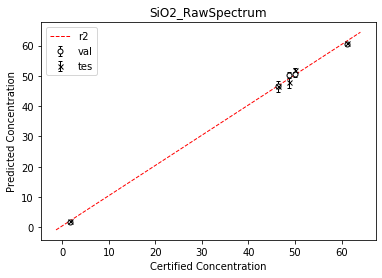

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [5.173222802669341, 5.202325740108873, 0.054707195705833864, nan, 1.3476161397220372, 0.9984401978405957]
cal_true = ['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.56459802653584, 46.56668596897129, 60.588303746503115, 50.293533956694056, 1.9085581993803984], ['cal_stander_derivation', 0.7912633875135562, 0.4193732144886281, 0.08881063328945302, 0.8469700667978611, 0.0947549841272168]]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.56459802653584, 46.56668596897129, 60.588303746503115, 50.293533956694056, 1.9085581993803984], ['cal_stander_derivation', 0.7912633875135562, 0.4193732144886281, 0.08881063328945302, 0.8469700667978611, 0.09475498

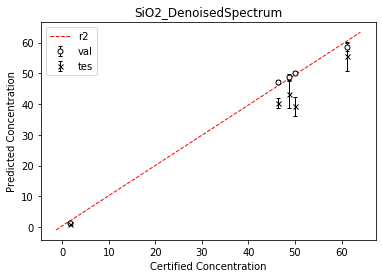

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [5.144444964694203, 5.1180917138222535, 0.18934238786264174, nan, 2.2585922421693776, 0.996378639352779]
cal_true = ['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.2531903779171, 47.33739752753205, 58.51990296250592, 48.77076656642009, 1.4273417626979186], ['cal_stander_derivation', 0.514096613008039, 0.515751162839743, 1.300731834369588, 1.0542614219554987, 0.3167218894950381]]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.2531903779171, 47.33739752753205, 58.51990296250592, 48.77076656642009, 1.4273417626979186], ['cal_stander_derivation', 0.514096613008039, 0.515751162839743, 1.300731834369588, 1.0542614219554987, 0.3167218894950381]]
X_tr

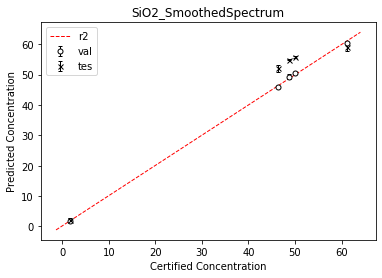

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [5.155780515911064, 5.15118444865901, 0.15955152377702947, nan, 0.9055228073950481, 0.9994484845396463]
cal_true = ['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.38579820043243, 46.0534033638872, 60.392337204071616, 49.29273186154898, 1.6928059359784993], ['cal_stander_derivation', 0.22982897367884234, 0.2925953158951218, 0.05737102599683368, 0.8689376508377936, 0.05272363146937975]]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.38579820043243, 46.0534033638872, 60.392337204071616, 49.29273186154898, 1.6928059359784993], ['cal_stander_derivation', 0.22982897367884234, 0.2925953158951218, 0.05737102599683368, 0.8689376508377936, 0.05272363146

X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 175824
error = [-3.78387255e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 262855
error = [2.4967111e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 244372
error = [-3.22852235e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 233104
error = [-6.79673173e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 558322
error = [-2.54335707e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 440922
error = [1.40067523e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 563353
error = [3.04302555e-10]
indexi = 0
indexi = 1
batch_size = 1
k = 145527
error = [4.74237759e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 154657
error = [-4.24775204e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 2102
error = [-2.63374866e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 398332
error = [-5.86411619e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 62212
error = [4.14467608e-08]
indexi = 0
indexi = 1
batch_size = 1
k 

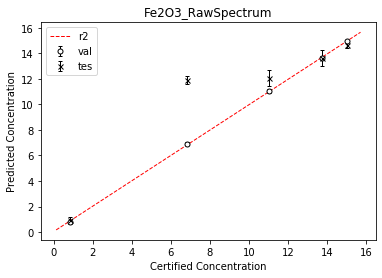

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [2.414442421784609, 2.4119087085045616, 0.19441928531823394, nan, 0.25401196601817, 0.9998619701539743]
cal_true = ['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.948869765434365, 11.027894509257765, 6.923703410655796, 13.623517163775501, 0.8269322699605385], ['cal_stander_derivation', 0.019278350499924768, 0.16458255293266882, 0.1370605113603494, 0.07833372037900242, 0.021644743731757652]]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.948869765434365, 11.027894509257765, 6.923703410655796, 13.623517163775501, 0.8269322699605385], ['cal_stander_derivation', 0.019278350499924768, 0.16458255293266882, 0.1370605113603494, 0.07833372037900242, 0.021644743731757652]]
X_tr.shape =

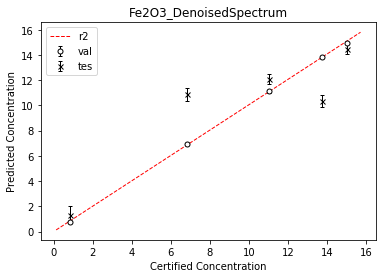

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [2.4167264464905838, 2.4346457334790177, 0.3145891811363746, nan, 0.15760114367263273, 0.9997080114366874]
cal_true = ['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.982694546496283, 11.129815558226628, 6.947835723180728, 13.85533033064914, 0.7965952626306444], ['cal_stander_derivation', 0.002575222996638941, 0.11012053615001433, 0.03921467679945708, 0.059527103232453006, 0.05273061831952968]]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.982694546496283, 11.129815558226628, 6.947835723180728, 13.85533033064914, 0.7965952626306444], ['cal_stander_derivation', 0.002575222996638941, 0.11012053615001433, 0.03921467679945708, 0.059527103232453006, 0.05273061831952968]]
X_tr.shap

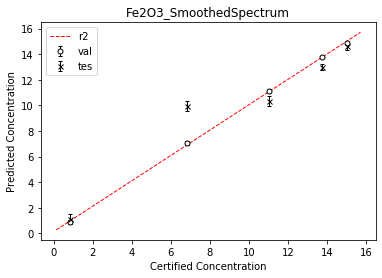

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [2.420368304826332, 2.4277698947420676, 0.1853143327870907, nan, 0.20983164196482532, 0.9992033382295433]
cal_true = ['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.831672898006394, 11.144742785982197, 7.084413860629558, 13.805386275823002, 0.8671248864977046], ['cal_stander_derivation', 0.004284615691714929, 0.10857680086946082, 0.14793991570168435, 0.050506985678550616, 0.03514850913480669]]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.831672898006394, 11.144742785982197, 7.084413860629558, 13.805386275823002, 0.8671248864977046], ['cal_stander_derivation', 0.004284615691714929, 0.10857680086946082, 0.14793991570168435, 0.050506985678550616, 0.03514850913480669]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 184026
error = [-3.19863589e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 405328
error = [-2.13797515e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 464309
error = [-5.42469891e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 264868
error = [-4.11800707e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 340555
error = [5.74521308e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 192226
error = [3.15666016e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 80830
error = [-2.70991571e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 270774
error = [-3.95593067e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 209022
error = [2.03803506e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 23498
error = [-9.7925279e-10]
indexi = 0
indexi = 1
batch_size = 1
k = 306344
error = [-1.2824153e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 198160
error = [4.99427946e-08]
indexi = 0
indexi = 1
batch_size = 1
k

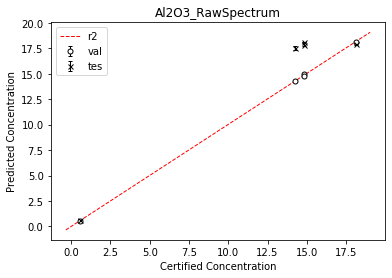

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.66511750654542, 4.675701302417251, 0.16380798224870416, nan, 0.10237688979559154, 0.9998537822060214]
cal_true = ['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.978326193156699, 18.13160115075718, 14.259009972066426, 14.798863736612255, 0.531659204954848], ['cal_stander_derivation', 0.07061358683963923, 0.0016342104052963732, 0.045727731252160425, 0.04220942595774511, 0.01071137285818176]]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.978326193156699, 18.13160115075718, 14.259009972066426, 14.798863736612255, 0.531659204954848], ['cal_stander_derivation', 0.07061358683963923, 0.0016342104052963732, 0.045727731252160425, 0.04220942595774511, 0.01071137285818176]]
X_tr.s

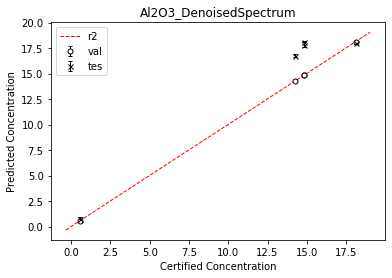

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.668209708499416, 4.671679459980101, 0.19426624053846162, nan, 0.0679296054877823, 0.9999576112460089]
cal_true = ['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.905814885905492, 18.132988139102917, 14.222481548675853, 14.852737938305555, 0.549622096620878], ['cal_stander_derivation', 0.039013478751849774, 0.0018603278149905774, 0.034153750517038915, 0.032548437952564666, 0.005630924942028197]]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.905814885905492, 18.132988139102917, 14.222481548675853, 14.852737938305555, 0.549622096620878], ['cal_stander_derivation', 0.039013478751849774, 0.0018603278149905774, 0.034153750517038915, 0.032548437952564666, 0.005630924942028197]

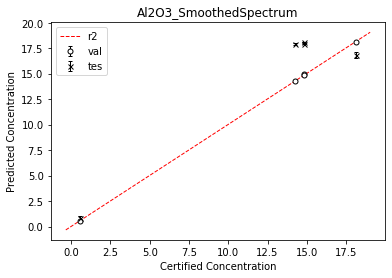

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.665891670116625, 4.674864220773374, 0.24932769502722038, nan, 0.14761162017502913, 0.9999175676187092]
cal_true = ['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.933302017202159, 18.117319109523546, 14.233899973419705, 14.879761492488635, 0.5388681113370679], ['cal_stander_derivation', 0.08522957900605957, 0.002863330558801754, 0.04193736991956795, 0.10482248953124529, 0.011389434100481235]]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.933302017202159, 18.117319109523546, 14.233899973419705, 14.879761492488635, 0.5388681113370679], ['cal_stander_derivation', 0.08522957900605957, 0.002863330558801754, 0.04193736991956795, 0.10482248953124529, 0.011389434100481235]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 841050
error = [-4.93291161e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 653126
error = [-9.74423484e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 821729
error = [1.97306964e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 846537
error = [4.53497283e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 631281
error = [-9.76363966e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 798564
error = [1.79335169e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 597400
error = [-1.59112908e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 673037
error = [3.19673538e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 654504
error = [-1.09664309e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 749618
error = [3.1544322e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 28623
error = [-3.09280826e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 892406
error = [-3.48531393e-08]
indexi = 0
indexi = 1
batch_size = 1


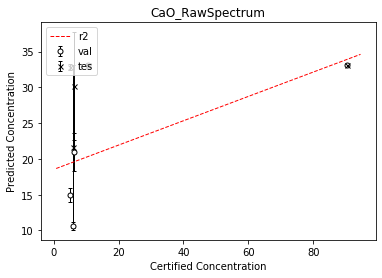

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [2.2260528693511024, 2.152928940629769, 2.948784302044065, nan, 14.77595616642046, -8.637892101007882]
cal_true = ['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 21.00259109624757, 33.10821413599917, 14.916266399008936, 10.6198457024992, 33.10821413599917], ['cal_stander_derivation', 2.646103847795601, 0.0, 1.0047245187297915, 0.5402116411573797, 0.0]]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 21.00259109624757, 33.10821413599917, 14.916266399008936, 10.6198457024992, 33.10821413599917], ['cal_stander_derivation', 2.646103847795601, 0.0, 1.0047245187297915, 0.5402116411573797, 0.0]]
X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
bat

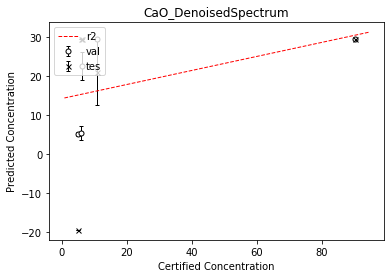

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [1.810398041851582, 1.7725906310299202, 2.8445810905584255, nan, 19.555671202511448, -6.095484063078353]
cal_true = ['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 22.588615820404584, 29.542639565813094, 5.174441091066196, 5.497687992261766, 29.542639565813094], ['cal_stander_derivation', 3.5413220864249393, 0.0, 0.5217999021496855, 1.7924748608706267, 0.0]]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 22.588615820404584, 29.542639565813094, 5.174441091066196, 5.497687992261766, 29.542639565813094], ['cal_stander_derivation', 3.5413220864249393, 0.0, 0.5217999021496855, 1.7924748608706267, 0.0]]
X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 4

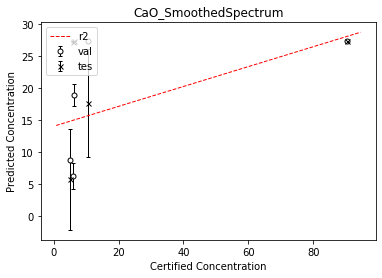

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [1.6352867199929944, 1.6133835326487775, 1.7026982952829364, nan, 14.144869354537217, -10.093090610886225]
cal_true = ['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 18.950234359531468, 27.352887255121296, 8.786085299173267, 6.290952914768255, 27.352887255121296], ['cal_stander_derivation', 1.690394995358108, 2.960594732333751e-17, 3.5888399637448994e-05, 1.9712121568548926, 0.0]]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 18.950234359531468, 27.352887255121296, 8.786085299173267, 6.290952914768255, 27.352887255121296], ['cal_stander_derivation', 1.690394995358108, 2.960594732333751e-17, 3.5888399637448994e-05, 1.9712121568548926, 0.0]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 244333
error = [4.38928888e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 266788
error = [-2.25852897e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 227465
error = [-1.87934608e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 99932
error = [3.73197465e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 229450
error = [-3.85000951e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 70861
error = [4.73178993e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 62433
error = [-1.04176965e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 175851
error = [-1.09680611e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 326618
error = [2.38208882e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 280835
error = [2.31998317e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 211418
error = [-1.27467932e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 61853
error = [-1.34510394e-08]
indexi = 0
indexi = 1
batch_size = 1
k 

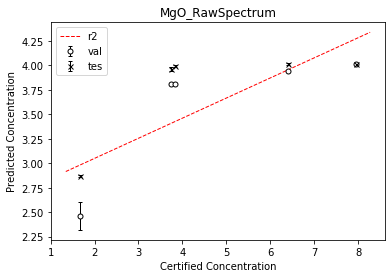

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [0.4675003228449047, 0.4699321328282403, 0.3400772396310906, nan, 0.4260192241075106, -12.280880911638459]
cal_true = ['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.8086755747378986, 4.019444165723798, 2.46257204639925, 3.8103481824540144, 3.943135495853915], ['cal_stander_derivation', 0.0005614097894608058, 3.95474528810021e-06, 0.14443195799087932, 0.0009238093388264831, 1.5378387050642612e-05]]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.8086755747378986, 4.019444165723798, 2.46257204639925, 3.8103481824540144, 3.943135495853915], ['cal_stander_derivation', 0.0005614097894608058, 3.95474528810021e-06, 0.14443195799087932, 0.0009238093388264831, 1.5378387050642612e-05]]
X_tr.shape = 

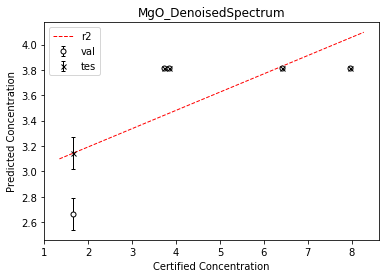

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [0.4545846204422861, 0.4580773276480086, 0.36909169471489145, nan, 0.5199176994732293, -22.449379296209496]
cal_true = ['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.815165810872784, 3.815165810872784, 2.6629758467204527, 3.815165810872784, 3.815165810872784], ['cal_stander_derivation', 0.0, 0.0, 0.12489747381039766, 0.0, 0.0]]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.815165810872784, 3.815165810872784, 2.6629758467204527, 3.815165810872784, 3.815165810872784], ['cal_stander_derivation', 0.0, 0.0, 0.12489747381039766, 0.0, 0.0]]
X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 318499
error = [-7.53200952e-09]


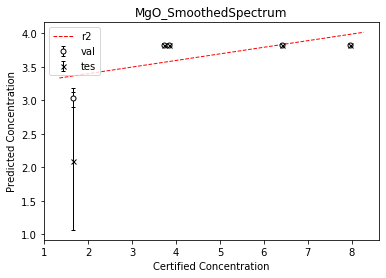

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [0.45671069024413763, 0.45539067354538754, 0.24253230638957332, nan, 0.860959016740382, -50.85170860985001]
cal_true = ['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.82306216317518, 3.8230932224469796, 3.0361643537487755, 3.8230257017168565, 3.823106000854844], ['cal_stander_derivation', 0.0, 0.0, 0.1412645161061425, 0.0, 0.0]]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.82306216317518, 3.8230932224469796, 3.0361643537487755, 3.8230257017168565, 3.823106000854844], ['cal_stander_derivation', 0.0, 0.0, 0.1412645161061425, 0.0, 0.0]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 114546
error = [-4.13415296e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 885528
error = [1.66867929e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 485796
error = [-3.21736628e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 49855
error = [1.51483738e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 177584
error = [-3.43801246e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 280053
error = [-8.95858254e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 53259
error = [4.49311423e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 63507
error = [1.51561727e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 636990
error = [7.15879758e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 109886
error = [-8.89534346e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 894066
error = [1.83799256e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 152675
error = [-4.8223097e-08]
indexi = 0
indexi = 1
batch_size = 1
k =

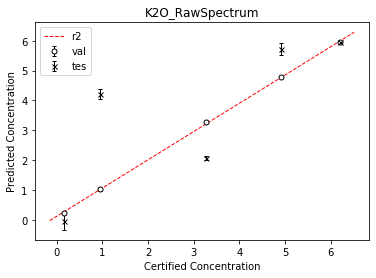

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.573359288032924, 4.561751120934489, 1.047248162240213, nan, 0.07671376122997692, 0.9960778322536302]
cal_true = ['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 5.9524391149613995, 1.0256383006719159, 4.78343277073662, 3.283709283394378, 0.21651677669886524], ['cal_stander_derivation', 0.0012724406647994493, 0.05474642051149896, 0.027081067153804605, 0.033895616677385124, 0.004203348088120818]]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 5.9524391149613995, 1.0256383006719159, 4.78343277073662, 3.283709283394378, 0.21651677669886524], ['cal_stander_derivation', 0.0012724406647994493, 0.05474642051149896, 0.027081067153804605, 0.033895616677385124, 0.004203348088120818]]
X_tr.shap

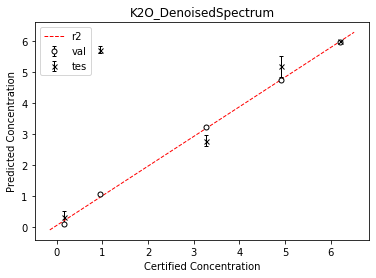

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.525713284249452, 4.554486056465993, 1.2511187157640138, nan, 0.07332955011149096, 0.9956074788865672]
cal_true = ['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 5.976541338083152, 1.0619152495551711, 4.734778985472681, 3.21199506408692, 0.08859021527979781], ['cal_stander_derivation', 0.003841308050529298, 0.02467839484397325, 0.0408776975824003, 0.02881434271903445, 0.01891413083803313]]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 5.976541338083152, 1.0619152495551711, 4.734778985472681, 3.21199506408692, 0.08859021527979781], ['cal_stander_derivation', 0.003841308050529298, 0.02467839484397325, 0.0408776975824003, 0.02881434271903445, 0.01891413083803313]]
X_tr.shape = (40, 10

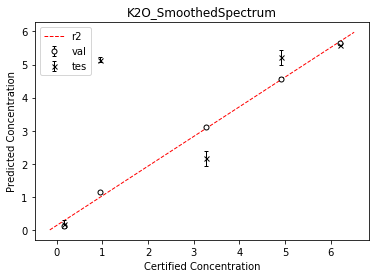

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.357043679376769, 4.387855751311472, 1.001477348624796, nan, 0.09042936311618635, 0.9763164742944809]
cal_true = ['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 5.638990365165624, 1.1409172540600883, 4.5724031942221375, 3.116784745865158, 0.11162879048212318], ['cal_stander_derivation', 0.001600768196468564, 0.025897996886380895, 0.039768559858412794, 0.018097938074079122, 0.04990980635172535]]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 5.638990365165624, 1.1409172540600883, 4.5724031942221375, 3.116784745865158, 0.11162879048212318], ['cal_stander_derivation', 0.001600768196468564, 0.025897996886380895, 0.039768559858412794, 0.018097938074079122, 0.04990980635172535]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 182095
error = [-2.94029598e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 181998
error = [-6.4814053e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 151714
error = [1.97187281e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 158992
error = [1.79750566e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 19304
error = [4.7610009e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 9595
error = [-2.02671124e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 101192
error = [-3.8783521e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 243572
error = [3.5812463e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 126267
error = [-2.81040169e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 269269
error = [-3.18028046e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 734730
error = [-1.27817179e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 8210
error = [-2.22225438e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 17

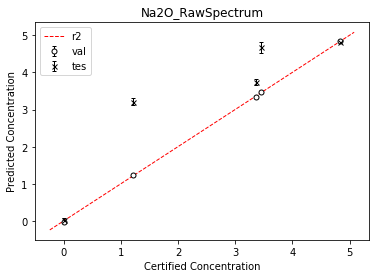

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.03876321414355915, 0.9998901548342783]
cal_true = ['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.2436502717893305, 3.3407421422613512, 3.469932095383243, 4.8345341240448185, -0.013601428387864219], ['cal_stander_derivation', 0.03186355781928709, 0.014421142431261006, 0.011419330964809666, 9.281759379293763e-05, 0.006795301772563484]]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.2436502717893305, 3.3407421422613512, 3.469932095383243, 4.8345341240448185, -0.013601428387864219], ['cal_stander_derivation', 0.03186355781928709, 0.014421142431261006, 0.011419330964809666, 9.281759379293763e-05, 0.006795301772563484]]
X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,

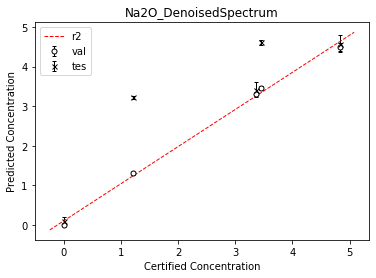

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.1460152063462779, 0.9909104208801582]
cal_true = ['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.3047134934364861, 3.311312907129811, 3.456438547406544, 4.504160589275075, 0.0004709553729413914], ['cal_stander_derivation', 0.04387010182156623, 0.03370354956277006, 0.04200533114403191, 0.09617089204154199, 0.01289576279391552]]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.3047134934364861, 3.311312907129811, 3.456438547406544, 4.504160589275075, 0.0004709553729413914], ['cal_stander_derivation', 0.04387010182156623, 0.03370354956277006, 0.04200533114403191, 0.09617089204154199, 0.01289576279391552]]
X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
ba

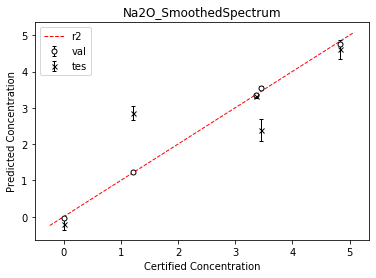

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.06523672796813111, 0.9988112230931169]
cal_true = ['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.234646741128633, 3.346338374025371, 3.559517467237535, 4.772089888678101, -0.034569763866135826], ['cal_stander_derivation', 0.02849516859207336, 0.006644575359491178, 0.04659702705600163, 0.019513990822936415, 0.007511411903611761]]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.234646741128633, 3.346338374025371, 3.559517467237535, 4.772089888678101, -0.034569763866135826], ['cal_stander_derivation', 0.02849516859207336, 0.006644575359491178, 0.04659702705600163, 0.019513990822936415, 0.007511411903611761]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 432816
error = [-3.09739554e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 649830
error = [4.30003289e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 391311
error = [-3.69209538e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 631626
error = [3.90565839e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 82432
error = [1.18831439e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 672955
error = [-1.5361582e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 26729
error = [4.32965269e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 489270
error = [-2.34998822e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 659593
error = [-4.52976651e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 1282945
error = [6.11983075e-10]
indexi = 0
indexi = 1
batch_size = 1
k = 59977
error = [-9.23611704e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 465341
error = [4.00110673e-08]
indexi = 0
indexi = 1
batch_size = 1
k 

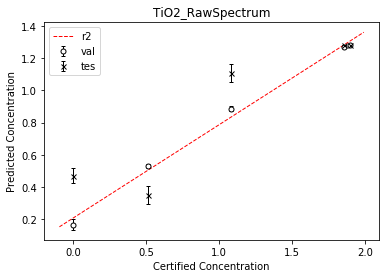

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.062270855539661975, 0.14930198272611006]
cal_true = ['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.2687228760745306, 0.5307877131637331, 0.8854439025678985, 1.2837038060176493, 0.16622633973693804], ['cal_stander_derivation', 0.0008139710454798776, 0.010006541799297141, 0.016631293923498124, 4.894772185902359e-05, 0.03254834963095534]]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.2687228760745306, 0.5307877131637331, 0.8854439025678985, 1.2837038060176493, 0.16622633973693804], ['cal_stander_derivation', 0.0008139710454798776, 0.010006541799297141, 0.016631293923498124, 4.894772185902359e-05, 0.03254834963095534]]
X_tr.shape = (40, 100)
y_tr.shape = (40, 

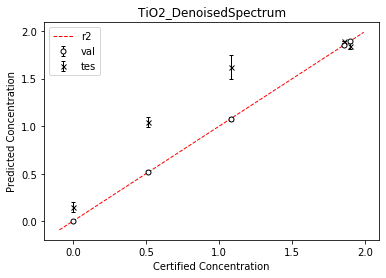

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.02537855273244629, 0.9999350589414214]
cal_true = ['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.8507384077357405, 0.5206435344746253, 1.0786523733496005, 1.8951161137491124, -0.001905764678342458], ['cal_stander_derivation', 0.00280058296851388, 0.013322391426812807, 0.022030118659821525, 8.883661046631408e-05, 0.003872409010670963]]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.8507384077357405, 0.5206435344746253, 1.0786523733496005, 1.8951161137491124, -0.001905764678342458], ['cal_stander_derivation', 0.00280058296851388, 0.013322391426812807, 0.022030118659821525, 8.883661046631408e-05, 0.003872409010670963]]
X_tr.shape = (40, 100)
y_tr.shape = (40, 

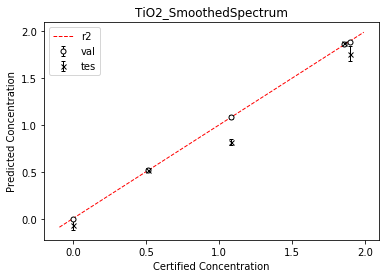

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.018917780678846505, 0.9999008287464546]
cal_true = ['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.8625258423727058, 0.5183460372746368, 1.0876014453767697, 1.8839716991793394, -0.00018225072542638656], ['cal_stander_derivation', 0.00221991987378324, 0.00782887326770682, 0.018651301518440886, 0.00031881154636630437, 0.002369882723774903]]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.8625258423727058, 0.5183460372746368, 1.0876014453767697, 1.8839716991793394, -0.00018225072542638656], ['cal_stander_derivation', 0.00221991987378324, 0.00782887326770682, 0.018651301518440886, 0.00031881154636630437, 0.002369882723774903]]




In [10]:
#!/usr/bin/python3
# coding: utf-8
import pandas as pd
import numpy as np
from time import time
import os
import random
import xlrd
import xlwt
import sys
from scipy import optimize
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import manifold
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

########################################################################################################################
# 线性拟合
def f_1(x, a, b):
    return a * x + b

########################################################################################################################
# 除去重复
def remove_duplicate(x):  # the input should be the list style
    x = x.reshape(1, -1)
    x = x[0, :].tolist()
    output = []
    for i in x:
        if i not in output:
            output.append(i)
    return output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single(spectra):
    spectra_max = np.max(spectra, axis=1)
    spectra_max = spectra_max.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    spectra_output = spectra*spectra_mean/spectra_max
    return spectra_output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single_1(spectra):
    wh = np.where(spectra == np.max(spectra))
    spectra_max = spectra[:, wh[1][0]]
    spectra_max = spectra_max.reshape(-1, 1)
    spectra_mean = np.mean(spectra_max)
    spectra_output = spectra * spectra_mean / spectra_max
    return spectra_output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single_2(spectra):
    spectra_mean_single = np.mean(spectra, axis=1)
    spectra_mean_single = spectra_mean_single.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    spectra_output = spectra * spectra_mean / spectra_mean_single
    return spectra_output

########################################################################################################################
# 归一化样品的能量
def normalize(spectra, group_set):
    X_output = np.zeros((spectra.shape[0], spectra.shape[1]))
    temp = remove_duplicate(group_set)
    group_set = group_set[:, 0].tolist()
    for indexj in range(len(temp)):
        temp_order = [i for i, x in enumerate(group_set) if x == temp[indexj]]
        X_temp = spectra[temp_order, :]
        X_temp = normalize_single_1(X_temp)
        X_output[temp_order] = X_temp
    return X_output

########################################################################################################################
# 归一化样品的能量
def normalize1(spectra):
    spectra_mean_single = np.mean(spectra, axis=1)
    spectra_mean_single = spectra_mean_single.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    X_output = spectra * spectra_mean / spectra_mean_single
    return X_output

########################################################################################################################
# 相对标准差
def relative_standard_derivation(x_predict, x_te):  # the imput should be the list style
    output = np.std((x_predict - x_te) / x_te) #* np.sqrt(len(x_te) / (len(x_te) - 1))
    return output

########################################################################################################################
# 相对偏差
def relative_error(x_predict, x_true):  # the imput should be the list style
    output = np.mean(abs(x_predict - x_true) / x_true)
    return output

########################################################################################################################
# limited of detection
def limited_of_detection(slope, rsd_calibration):
    output = 3 * np.mean(rsd_calibration) / slope
    return output

def relu(x):
    return np.maximum(x, 0.0)

def relu_deriv(x):
    x[x > 0] = 1.0
    x[x <= 0] = 0.0
    return x

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)*np.tanh(x)

def logistic(x):
    return 1/(1+np.exp(-x))

def logistic_derivative(x):
    return logistic(x)*(1-logistic(x))

def prelu(x):
    return np.maximum(x, 0.0) + 0.25*np.minimum(x, 0.0)

def prelu_deriv(x):
    x[x > 0] = 1.0
    x[x < 0] = 0.25
    return x

class BPNNet:

    def __init__(self, layers, activation=["tanh", "tanh"], batch_size="None"):
        self.layers = layers
        # active function
        self.activation = activation
        if self.activation[0] == 'logistic':
            self.activation0 = logistic
            self.activation0_deriv = logistic_derivative
        elif self.activation[0] == 'tanh':
            self.activation0 = tanh
            self.activation0_deriv = tanh_deriv
        elif self.activation[0] == 'relu':
            self.activation0 = relu
            self.activation0_deriv = relu_deriv
        elif self.activation[0] == 'prelu':
            self.activation0 = prelu
            self.activation0_deriv = prelu_deriv
        if self.activation[1] == 'logistic':
            self.activation1 = logistic
            self.activation1_deriv = logistic_derivative
        elif self.activation[1] == 'tanh':
            self.activation1 = tanh
            self.activation1_deriv = tanh_deriv
        elif self.activation[1] == 'relu':
            self.activation1 = relu
            self.activation1_deriv = relu_deriv
        elif self.activation[1] == 'prelu':
            self.activation1 = prelu
            self.activation1_deriv = prelu_deriv
        # batch_size
        if batch_size == "None":
            self.batch_size = 0
        else:
            self.batch_size = batch_size
        # random weights & weights updates
        self.weights = []
        self.weights.append((2*np.random.random((layers[0]+1,layers[1]))-1)*0.25)
        for i in range(2,len(self.layers)):
            self.weights.append((2*np.random.random((layers[i - 1],layers[i])) - 1) * 0.25)
        # random weights & weights updates
        self.updates = []
        self.updates.append(np.zeros((self.layers[0] + 1, self.layers[1])))
        for i in range(2,len(self.layers)):
            self.updates.append(np.zeros((self.layers[i - 1], self.layers[i])))
    def fit(self, X, y, learning_rate_max=0.3, learning_rate_min=0.1, epochs=2000000, error_threshold=1e-8):  # learning_rate=0.2
        # self.weights 的数据更新
        self.weights[0] = (2*np.random.random((self.layers[0]+1, self.layers[1]))-1)*0.25
        for i in range(2, len(self.layers)):
            self.weights[i - 1] = (2*np.random.random((self.layers[i - 1],self.layers[i])) - 1) * 0.25
        #print(self.weights)
        # atlest_2d函数:确认X至少二位的矩阵
        X = np.atleast_2d(X)
        # 初始化矩阵全是1（行数，列数+1是为了有B这个偏向）
        temp = np.ones([X.shape[0], X.shape[1]+1])
        # 行全选，第一列到倒数第二列
        temp[:,0:-1]=X
        X = temp
        # 真实值的y数组
        y = np.array(y)
        # batch_size 的mini_batch计算
        batch_size = int(self.batch_size * X.shape[0])+1
        print('batch_size = '+str(batch_size))
        # epoch 每一次循环的BP
        for k in range(epochs):
            learning_rate = learning_rate_max - (learning_rate_max-learning_rate_min) * k/epochs
            # mini_batch 随机取出规定数目的序号list
            order = random.sample(range(X.shape[0]), batch_size)
            #print(order)
            # self.updates 的数据更新
            self.updates[0] = np.zeros((self.layers[0] + 1, self.layers[1]))
            for i in range(2, len(self.layers)):
                self.updates[i-1] = np.zeros((self.layers[i - 1], self.layers[i]))
            # print(self.updates)
            # mini_batch 梯度下降抽样
            error = 0
            error_cache = 1
            for j in range(batch_size):
                temp_j = order[j]
                # 根据order产生的随机数数列，循环每次一个样本
                a = [X[temp_j]]
                a.append(self.activation0(np.dot(a[0], self.weights[0])))
                a.append(self.activation1(np.dot(a[1], self.weights[1])))
                # 向前传播，得到每个节点的输出结果
                error_temp = y[temp_j] - a[-1]
                error += error_temp
            error = error/batch_size   # 最后一层错误率
            deltas = [error * self.activation1_deriv(a[-1])]
            deltas.append(deltas[-1].dot(self.weights[1].T) * self.activation0_deriv(a[1]))
            deltas.reverse()
            if abs(error) <= error_threshold:
                print('k = '+str(k))
                print('error = '+str(error))
                break
            elif k==epochs-1:
                self.weights = weights_cache
                print('iteration steps out of band')
                print('error = '+str(error_cache))
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.updates[i] += learning_rate * layer.T.dot(delta)
            for i in range(len(self.updates)):
                self.weights[i] += self.updates[i]/batch_size
            if error < error_cache:
                error_cache = error
                weights_cache = self.weights
    def predict(self, x):
        # x=np.array(x)
        r1, c1 = x.shape
        aa = np.ones(shape=[r1, 1])
        for indexi in range(r1):
            temp = np.ones(c1 + 1)
            temp[0:-1] = x[indexi].T
            a = temp
            a = self.activation0(np.dot(a, self.weights[0]))
            a = self.activation1(np.dot(a, self.weights[1]))
            aa[indexi] = a
        return (aa)
    def load_weights(self, path_load):
        '''''
        worksheet = xlrd.open_workbook(path_load)
        sheet_names = worksheet.sheet_names()
        '''''
        for indexi in range(len(self.weights)):
            data = pd.read_excel(path_load, sheet_name=str(indexi),
                                 header=0, skiprows=0)
            self.weights[indexi] = np.array(data)

    def save_weights(self, path_save):
        '''''
        workbook = xlwt.Workbook(encoding='ascii')

        for indexi in range(len(self.weights)):
            cmp = self.weights[indexi]
            worksheet = workbook.add_sheet(str(indexi))
            for i in range(len(cmp)):
                for j, k in enumerate(cmp[i]):
                    worksheet.write(i, j, k)
        workbook.save(path_save)
        '''''
        with pd.ExcelWriter(path_save) as writer:
            for indexi in range(len(self.weights)):
                print('indexi = '+str(indexi))
                data = self.weights[indexi]
                data = pd.DataFrame(data)
                data.to_excel(writer, sheet_name=str(indexi), index=False, header=False)
'''
    def rigidity_normalization(y, range0=range(300,320), range1=range(400,420)):
        peek0 = np.max(y[range0])
        peek1 = np.max(y[range1])
        rigidity = peek0 / peek1
        y = y / rigidity
        return y
'''
#  BPNNet
########################################################################################################################
#本部分可调
learning_rate_max_whole = 0.30
learning_rate_min_whole = 0.10
epochs_whole = 2000000
batch_size_whole = 0
threshold = 5e-8
########################################################################################################################
# active function

########################################################################################################################
date = '20191226'
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
    for process in tqdm_notebook(['RawSpectrum']):
        try_num = 1
        #process = 'SmoothedSpectrum' #DenoisedSpectrum SmoothedSpectrum
        data_file_path = os.path.join(r'D:\data\china_2020\coeffs_dwt\coeffs_cut', choose_element)
        menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
        save_path_file = os.path.join(r'D:\data\china_2020\result\BPNN results', date, choose_element+'_'+str(try_num))
        if not os.path.exists(save_path_file):
            os.mkdir(save_path_file)
        save_path_file = os.path.join(save_path_file, process)
        if not os.path.exists(save_path_file):
            os.mkdir(save_path_file)
        #process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
        choose_type = 'Soil_Type'
        file_list = 'Spectra_Name'
        sample_list = 'Spectra_Name'
        data_flag = pd.read_excel(menu_guide_path)
        file_names = np.array(data_flag[file_list])
        concentration = np.array(data_flag[choose_element])
        sample_type = np.array(data_flag[choose_type])
        sample_name_unique = np.array(data_flag[sample_list])
        train_test_set = np.array(data_flag['Train']).tolist()
        type_list = data_flag[choose_type].drop_duplicates(keep='first').tolist()
        p = 150  #p可调
        ########################################################################################################################
        # train list
        #train_position = [i for i, j in enumerate(train_test_set) if j == 1]
        train_position = [1, 3, 12, 13, 21]
        # test list
        #test_position = [i for i, j in enumerate(train_test_set) if j == 0]
        test_position = [1, 3, 12, 13, 21]
        ########################################################################################################################
        # Input Data

        state = 'pellet'
        X_tr = None
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for i in range(8):
                file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i)+'.txt'
                read_path = os.path.join(data_file_path, file)
                if not os.path.exists(read_path):
                    print(read_path)
                    continue
                data_cache = np.loadtxt(read_path)
                data_cache = data_cache.flatten()
                #data_cache = np.mean(data_cache, axis=0)
                if X_tr is None:
                    X_tr = data_cache
                    y_tr = temp_concentration
                    group_tr = index_i
                else:
                    X_tr = np.row_stack((X_tr, data_cache))
                    y_tr = np.row_stack((y_tr, temp_concentration))
                    group_tr = np.row_stack((group_tr, index_i))
        print('X_tr.shape = '+str(X_tr.shape))
        print('y_tr.shape = '+str(y_tr.shape))

        state = 'rock'
        X_te = None
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for i in range(8):
                file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i)+'.txt'
                read_path = os.path.join(data_file_path, file)
                if not os.path.exists(read_path):
                    print(read_path)
                    continue
                data_cache = np.loadtxt(read_path)
                data_cache = data_cache.flatten()
                #data_cache = np.mean(data_cache, axis=0)
                if X_te is None:
                    X_te = data_cache
                    y_te = temp_concentration
                    group_te = index_i
                else:
                    X_te = np.row_stack((X_te, data_cache))
                    y_te = np.row_stack((y_te, temp_concentration))
                    group_te = np.row_stack((group_te, index_i))
        print('X_te.shape = '+str(X_te.shape))
        print('y_te.shape = '+str(y_te.shape))
        
        
        ########################################################################################################################
        # Te & Tr true concentration
        group_tr_remove_duplicate = remove_duplicate(group_tr)
        group_te_remove_duplicate = remove_duplicate(group_te)
        group_tr_temp = group_tr.reshape(1, -1)
        group_tr_temp = group_tr_temp[0, :].tolist()
        group_te_temp = group_te.reshape(1, -1)
        group_te_temp = group_te_temp[0, :].tolist()
        order_y_tr = [group_tr_temp.index(x) for x in group_tr_remove_duplicate]
        order_y_te = [group_te_temp.index(x) for x in group_te_remove_duplicate]
        y_tr_true = y_tr[order_y_tr,:]
        y_te_true = y_te[order_y_te,:]
        ########################################################################################################################
        # standard数据归一化
        '''
        min_max_scaler1 = preprocessing.MinMaxScaler()
        X_tr = min_max_scaler1.fit_transform(X_tr)
        X_te = min_max_scaler1.transform(X_te)
        min_max_scaler2 = preprocessing.MinMaxScaler()
        y_tr = min_max_scaler2.fit_transform(y_tr)
        y_te = min_max_scaler2.transform(y_te)
        min_max_scaler3 = preprocessing.MinMaxScaler()
        group_tr_add = min_max_scaler3.fit_transform(group_tr)
        group_te_add = min_max_scaler3.transform(group_te)
        '''
        ########################################################################################################################
        # standard数据归一化for different states
        min_max_scaler1 = preprocessing.MinMaxScaler()
        X_tr = min_max_scaler1.fit_transform(X_tr)
        min_max_scaler1_te = preprocessing.MinMaxScaler()
        X_te = min_max_scaler1_te.fit_transform(X_te)
        min_max_scaler2 = preprocessing.MinMaxScaler()
        y_tr = min_max_scaler2.fit_transform(y_tr)
        min_max_scaler2_te = preprocessing.MinMaxScaler()
        y_te = min_max_scaler2_te.fit_transform(y_te)
        min_max_scaler3 = preprocessing.MinMaxScaler()
        group_tr_add = min_max_scaler3.fit_transform(group_tr)
        min_max_scaler3_te = preprocessing.MinMaxScaler()
        group_te_add = min_max_scaler3_te.fit_transform(group_te)
        ########################################################################################################################



        r0, c0 = X_tr.shape
        print('r0,c0 = '+str(r0)+', '+str(c0))
        ########################################################################################################################

        k = 6
        rr = 10

        predict_train_temp = np.empty(shape=[len(y_tr_true), k * rr])
        predict_train_temp_rsd = np.empty(shape=[len(y_tr_true), k * rr])
        predict_val_temp = np.empty(shape=[len(y_tr_true), k * rr])
        predict_val_temp_rsd = np.empty(shape=[len(y_tr_true), k * rr])
        predict_tes_temp = np.empty(shape=[len(y_te), k * rr])

        nn = BPNNet([c0, 5, 1], ['tanh','tanh'], batch_size_whole)   #神经元个数5-8
        '''''
        REtes = 0.4
        R2 = 0.97
        loop1 = 1oop2 = 1
        while REtes>0.30  or R2<0.998:
            print("loop1:")
            print(loop1)
        '''''
        rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=rr)
        combine = list(rskf.split(X_tr, group_tr))
        indexi = 0
        t0 = time()


        for train_index, val_index in combine:
            X_train = X_tr[train_index]
            y_train = y_tr[train_index]
            group_train = group_tr[train_index]
            X_val = X_tr[val_index]
            y_val = y_tr[val_index]
            group_val = group_tr[val_index]
            nn.fit(X_train, y_train, learning_rate_max=learning_rate_max_whole, learning_rate_min=learning_rate_min_whole, epochs=epochs_whole, error_threshold=threshold)
            nn.save_weights(save_path_file + r'\weights' + str(indexi) + '.xlsx')

            temp = nn.predict(X_train)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            temp1 = remove_duplicate(group_train)
            group_train = group_train[:, 0].tolist()
            for indexj in range(len(temp1)):
                temp_order = [i for i, x in enumerate(group_train) if x == temp1[indexj]]
                predict_train_temp[indexj, indexi] = np.mean(temp[temp_order])
                predict_train_temp_rsd[indexj, indexi] = np.std(temp[temp_order])
                #* np.sqrt(len(temp_order) / (len(temp_order) - 1))

            temp = nn.predict(X_val)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            temp1 = remove_duplicate(group_val)
            group_val = group_val[:, 0].tolist()
            for indexj in range(len(temp1)):
                temp_order = [i for i, x in enumerate(group_val) if x == temp1[indexj]]
                predict_val_temp[indexj, indexi] = np.mean(temp[temp_order])
                predict_val_temp_rsd[indexj, indexi] = np.std(temp[temp_order])
                                                       #* np.sqrt(len(temp_order) / (len(temp_order) - 1))

            temp = nn.predict(X_te)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            predict_tes_temp[:, indexi] = temp[:, 0]

            indexi += 1
        print("done in %0.3fs" % (time() - t0))
        # 作图使用的calibration val && validation set的predicted value & errorbar
        #  predicted value
        predict_train = np.mean(predict_train_temp, axis=1)
        predict_train_rsd = np.mean(predict_train_temp_rsd, axis=1)
        predict_val = np.mean(predict_val_temp, axis=1)  # 作图用的calibration线
        predict_val_rsd = np.mean(predict_val_temp_rsd, axis=1)  # 作图用的calibration线的errorbar
        # test data set
        predict_tes = np.mean(predict_tes_temp, axis=1)
        temp1 = remove_duplicate(group_te)
        predict_te = np.empty(shape=[len(temp1), 1])  # 作图用的validation线
        predict_te_rsd = np.empty(shape=[len(temp1), 1])  # 作图用的validation线的errorbar
        group_te = group_te[:, 0].tolist()
        for indexj in range(len(temp1)):
            temp_order = [i for i, x in enumerate(group_te) if x == temp1[indexj]]
            predict_te[indexj, 0] = np.mean(predict_tes[temp_order])
            predict_te_rsd[indexj, 0] = np.std(predict_tes[temp_order]) #* np.sqrt(len(temp_order) / (len(temp_order) - 1))
        # 文章计算Slope 截距
        print('predict_val = '+str(predict_val))
        Slope, intercept = optimize.curve_fit(f_1, y_tr_true[:, 0], predict_val)[0]
        # 文章简图
        nn0 = 10
        start = np.min(y_tr_true) - (np.max(y_tr_true) - np.min(y_tr_true)) / 20.0
        stop = np.max(y_tr_true) + (np.max(y_tr_true) - np.min(y_tr_true)) / 20.0
        x1 = np.linspace(start, stop, num=nn0, endpoint=True)
        y1 = Slope * x1 + intercept  ##  拟合曲线
        plt.plot(x1, y1, color='r', linestyle='--', linewidth=1)
        plt.errorbar(y_tr_true, predict_val, yerr=predict_val_rsd, fmt='o', marker='o', mfc='white', mec='black', ms=5, mew=1,
                     ecolor='black', elinewidth=1, capsize=2)
        plt.errorbar(y_te_true, predict_te[:, 0], yerr=predict_te_rsd[:, 0], fmt='x', marker='x', mfc='white', mec='black',
                     ms=5, mew=1, ecolor='black', elinewidth=1, capsize=2)
        plt.legend(['r2', 'val', 'tes'],
                   loc='upper left',
                   numpoints=1,
                   fancybox=True)
        plt.xlabel('Certified Concentration')
        plt.ylabel('Predicted Concentration')
        plt.title(choose_element + '_' + process)
        plt.show()
        # 文章计算REC RET （使用y_tr_true）REP（使用y_te_true）
        REC = relative_error(predict_train, y_tr_true)
        RET = relative_error(predict_val, y_tr_true)
        REP = relative_error(predict_te, y_te_true)
        # 文章计算RSD(使用 predict_tes && y_te)
        RSD = relative_standard_derivation(predict_tes, y_te)
        # 文章计算LOD
        LOD = limited_of_detection(Slope, predict_val_rsd)
        # 文章计算R2（calibration曲线的r2）
        R2 = r2_score(predict_val, y_tr_true)
        ########################################################################################################################
        # print the results
        title = ["REC", "RET", "REP", "RSD", "LOD", "R2"]
        value = [REC, RET, REP, RSD, LOD, R2]
        print('title = '+str(title))
        print('value = '+str(value))
        ########################################################################################################################
        # save the results
        # Sheet 1
        # REC, RET, REP, RSD, LOD, R2 value
        cmp = [title, value]
        workbook = xlwt.Workbook(encoding='ascii')
        worksheet = workbook.add_sheet('Result')
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(i, j, k)
        # Sheet 2
        worksheet = workbook.add_sheet('Scatter')
        # calibration scatters value
        cal_true = ['cal_true']
        cal_predict = ['cal_predict']
        cal_stander_derivation = ['cal_stander_derivation']
        cal_true += y_tr_true[:,0].tolist()
        print('cal_true = '+str(cal_true))
        cal_predict += predict_val.tolist()
        cal_stander_derivation += predict_val_rsd.tolist()
        cmp0 = [cal_true, cal_predict, cal_stander_derivation]
        print('cmp0 = '+str(cmp0))
        for i in range(len(cmp0)):
            for j, k in enumerate(cmp0[i]):
                worksheet.write(j, i, k)
        # validation scatters value
        val_true = ['val_true']
        val_predict = ['val_predict']
        val_stander_derivation = ['val_stander_derivation']
        val_true += y_te_true[:, 0].tolist()
        val_predict += predict_te[:, 0].tolist()
        val_stander_derivation += predict_te_rsd[:, 0].tolist()
        cmp = [val_true, val_predict, val_stander_derivation]
        print('cmp0 = '+str(cmp0))
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(j, i+len(cmp0), k)
        # Sheet 3
        worksheet = workbook.add_sheet('fitting')
        # fitting line value
        fitting_x = ["fitting_x"]
        fitting_y = ["fitting_y"]
        fitting_x += x1.tolist()
        fitting_y += y1.tolist()
        cmp = [fitting_x, fitting_y]
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(j, i, k)
        workbook.save(os.path.join(save_path_file, r'result.xlsx'))



In [ ]:
#minus Dark for denoised and smoothed

point_number = 3
#file reading
#process_path = ['RawSpectrum_Dark', 'RawSpectrum_Raw', 'DenoisedSpectrum', 'SmoothedSpectrum']
orig_path = r'D:\data\china_2020\pixel_select'
rock_type = ['S2', 'S5', 'S17', 'S19', 'S30']
process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
save_path_root = r'D:\data\china_2020\pixel_select_corrected'
freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
freq = freq[:, 1]
for state in tqdm_notebook(['rock', 'pellet']):
    for i in tqdm_notebook(rock_type):
        for j in process_path:
            for z in range(point_number):
                data_raw = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'))
                data_dark = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + 'RawSpectrum' + '_Dark_' + str(z + 1) + '.txt'))
                data_raw = data_raw[:, 1:]
                data_dark = data_dark[:, 1:].dot(np.ones((1, data_raw.shape[1])))
                data_correct = data_raw - data_dark
                np.savetxt(os.path.join(save_path_root, i + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'), data_correct, '%.5g')

In [ ]:
#preprocess and wavelet transform

point_number = 3
#file reading
#process_path = ['RawSpectrum_Dark', 'RawSpectrum_Raw', 'DenoisedSpectrum', 'SmoothedSpectrum']
menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
data_flag = pd.read_excel(menu_guide_path)
orig_path = r'D:\data\china_2020\pixel_select'
rock_type = {'1': 'S2', '3': 'S5', '12': 'S17', '13': 'S19', '21': 'S30'}
process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
save_path_root = r'D:\data\china_2020\spectra_scores'
freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
freq = freq[:, 1]
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
    concentration = np.array(data_flag[choose_element])
    for state in tqdm_notebook(['rock', 'pellet']):
        for j in process_path:
            X_tr = None
            for i in [1, 3, 12, 13, 21]:
                for z in range(point_number):
                    data = np.loadtxt(os.path.join(orig_path, rock_type[str(i)] + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'))
                    data_processed = preprocess_2020(data[:, 1:]) #first column is pixel numbers
                    if X_tr is None:
                        X_tr = data_processed
                        y_tr = np.ones(8).reshape(-1, 1) * concentration[i]
                    else:
                        X_tr = np.row_stack((X_tr, data_processed))
                        y_tr = np.row_stack((y_tr, np.ones(8).reshape(-1, 1) * concentration[i]))
            skb = SelectKBest(f_regression, k=X_tr.shape[1])
            X_tr = skb.fit_transform(X_tr, y_tr.ravel())
            score = skb.scores_
            score = score.tolist()
            save_path = os.path.join(save_path_root, choose_element)
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            np.savetxt(os.path.join(save_path, state + '_' + j + '.txt'), score)
                    


In [ ]:
#for coeffs comparison
data_file_path = r'D:\data\china_2020\coeffs'
menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
point_number = 3
process_path = ['DenoisedSpectrum', 'SmoothedSpectrum', 'RawSpectrum']
file_list = 'Spectra_Name'
data_flag = pd.read_excel(menu_guide_path)
file_names = np.array(data_flag[file_list])
########################################################################################################################

train_position = [1, 3, 12, 13, 21]
for state in tqdm_notebook(['rock', 'pellet']):
    for process in process_path:
        X_tr = None
        for index_i in tqdm_notebook(train_position):
            for j in range(8):
                data_point = 0
                for i in range(point_number):
                    file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'.txt'
                    read_path = os.path.join(data_file_path, file)
                    if not os.path.exists(read_path):
                        print(read_path)
                        continue
                    data_point += np.loadtxt(read_path)
                data_cache = data_point / point_number
                np.savetxt(os.path.join(r'D:\data\china_2020\coeffs_mean', state+'_'+file_names[index_i]+'_'+process+'_'+str(j)+'.txt'), data_cache)